In [12]:
!pip install qulacs
!pip install matplotlib
!pip install numpy
!pip install scipy

You should consider upgrading via the '/usr/local/oss/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/oss/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/oss/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/oss/anaconda3/bin/python -m pip install --upgrade pip' command.


In [13]:
from qulacs import Observable, QuantumState, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt

# サンプリングによってオブザーバブルの期待値を推定する

## オブザーバブルを定義する

ここでは1次元ハイゼンベルグ模型
$$H = \sum_{i} J_{i} (X_iX_{i+1} + Y_iY_{1+1} + Z_iZ_{i+1})$$
を考える

In [14]:
n_qubits = 4
hamiltonian = Observable(n_qubits)
np.random.seed(1)
J_list = 2*np.random.rand(n_qubits)-1
for i in range(n_qubits):
    hamiltonian.add_operator(J_list[i], f"X {i} X {(i+1)%n_qubits}")
    hamiltonian.add_operator(J_list[i], f"Y {i} Y {(i+1)%n_qubits}")
    hamiltonian.add_operator(J_list[i], f"Z {i} Z {(i+1)%n_qubits}")

## 適当な状態を準備する

期待値測定をする対象として、適当な回路を通した状態を準備します。

In [15]:
state = QuantumState(n_qubits)
circuit = QuantumCircuit(n_qubits)
depth = 2
np.random.seed(2)
for d in range(depth):
    for i in range(n_qubits):
        circuit.add_U3_gate(i, *(2*np.pi*np.random.rand(3)))
    for i in range(n_qubits//2):
        circuit.add_CZ_gate((i+d%2)%n_qubits, (i+1+d%2)%n_qubits)
circuit.update_quantum_state(state)

厳密な期待値を計算すると以下のようになります。これをサンプリングによって再現するのが目標です。

In [16]:
hamiltonian.get_expectation_value(state)

-0.37299366575662646

## サンプリングをしてみる。

### $Z$ のサンプリング
$H_{ZZ} = \sum_i J_i Z_iZ_{i+1} $ の期待値 $\langle H \rangle$ を求めよう。$Z$ の固有ベクトルは $|0\rangle$, $|1\rangle$ なので、そのままサンプリングすれば OK です

In [17]:
def sample_ZZ(_n_shots):
    global J_list, state
    samples = state.sampling(_n_shots)
    estimated_Z_energy = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
#             print(f"{s:04b}, {bitcount}, {mask:04b}")
            estimated_Z_energy += J*(-1)**bitcount/_n_shots
    return estimated_Z_energy

1000個のビット列のサンプリングを1000回繰り返してヒストグラムに表示します

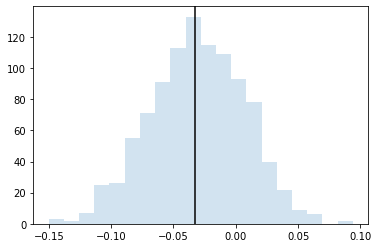

In [19]:
n_test = 1000
n_shots = 1000
result_list_ZZ = np.zeros(n_test)
for i in range(n_test):
    result_list_ZZ[i] = sample_ZZ(n_shots)
plt.hist(result_list_ZZ, alpha=0.2, bins=20)
hamiltonian_ZZ = Observable(n_qubits)
for i in range(n_qubits):
    hamiltonian_ZZ.add_operator(J_list[i], f"Z {i} Z {(i+1)%n_qubits}")
plt.axvline(hamiltonian_ZZ.get_expectation_value(state), color="black")
plt.show()

### $X$ のサンプリング
$X$ のサンプリングはそのままではできないです。$X=HZH$ を使って期待値を推定します。

In [20]:
# 演習
def sample_XX(_n_shots):
    pass

ValueError: autodetected range of [nan, nan] is not finite

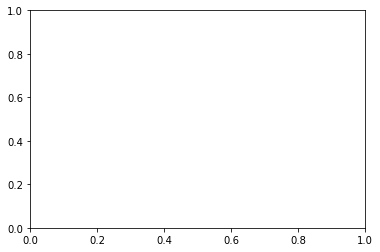

In [21]:
n_test = 1000
n_shots = 1000
result_list_XX = np.zeros(n_test)
for i in range(n_test):
    result_list_XX[i] = sample_XX(n_shots)
plt.hist(result_list_XX, alpha=0.2, bins=20)
hamiltonian_XX = Observable(n_qubits)
for i in range(n_qubits):
    hamiltonian_XX.add_operator(J_list[i], f"X {i} X {(i+1)%n_qubits}")
plt.axvline(hamiltonian_XX.get_expectation_value(state), color="black")
plt.show()

### $Y$ のサンプリング
$Y$ のサンプリングもそのままではできないので、$Y = SH Z HS^\dagger$ を使って推定します。

In [10]:
# 演習
def sample_XX(_n_shots):
    pass

In [11]:
n_test = 1000
n_shots = 1000
result_list_YY = np.zeros(n_test)
for i in range(n_test):
    result_list_YY[i] = sample_YY(n_shots)
plt.hist(result_list_YY, alpha=0.2, bins=20)
hamiltonian_YY = Observable(n_qubits)
for i in range(n_qubits):
    hamiltonian_YY.add_operator(J_list[i], f"Y {i} Y {(i+1)%n_qubits}")
plt.axvline(hamiltonian_YY.get_expectation_value(state), color="black")
plt.show()

NameError: name 'sample_YY' is not defined

### 全体のサンプリング結果

エネルギー期待値は 
$$\langle H \rangle = \langle H_{XX} \rangle + \langle H_{YY} \rangle + \langle H_{ZZ} \rangle $$
で求められます。

In [ ]:
result_list_total = result_list_XX + result_list_YY + result_list_ZZ
plt.hist(result_list_total, alpha=0.2, bins=20)
plt.axvline(hamiltonian.get_expectation_value(state), color="black")
plt.show()